In [19]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [20]:
#"""此note book为股票回测框架的示例"""

In [21]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [22]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
from BackTestingEngine import backTestingEngine as bte
#from config import *

In [23]:
path = ff.data_path

In [24]:
startTime =  datetime.strptime('20160504', '%Y%m%d')
endTime = datetime.strptime('20170228', '%Y%m%d')
initstartTime =  datetime.strptime('20160304', '%Y%m%d')
initendTime = datetime.strptime('20170328', '%Y%m%d')

In [25]:
filenameAdjOpen = 'OwnfactorAdjustedOpen.h5'
filenameAdjClose = 'OwnfactorAdjustedClose.h5'
filenameVolume = 'LZ_CN_STKA_QUOTE_TVOLUME.h5'

In [26]:
# 初始化
test = bte.StkBacktesting(path)

In [27]:
test.setInitCap(50000000)
test.availableCashNow

50000000

In [28]:
# 添加数据
test.addData('adjOpen',filenameAdjOpen)
test.addData('adjClose',filenameAdjClose)
test.addData('volume',filenameVolume)

In [29]:
# 截取回测区间和初始化区间
test.setBackTestingPeriod(startTime,endTime)
test.setInitialPeriod(initstartTime,initendTime)

In [30]:
# 双均线筛选买卖股
ma5 = test.dataDict['adjClose'].rolling(window=5, min_periods=5).mean()
ma20 = test.dataDict['adjClose'].rolling(window=20, min_periods=20).mean()
buyStk = ((ma5 > ma20) & ((ma5 < ma20).shift(1) )).shift(1).loc[test.backTestingDateList.tolist()]
sellStk = ((ma5 < ma20) & ((ma5 > ma20).shift(1) )).shift(1).loc[test.backTestingDateList]

In [31]:
test.getAllPosition()

{}

In [32]:
# 按天循环
for date in  test.backTestingDateList:
    #todayindex = test.backTestingDateList.tolist().index(date)
    #yesterday = test.backTestingDateList[todayindex -1]
    #print yesterday

    # 切片确定当天的买卖股票
    sellslice = sellStk.loc[date]
    sellList = sellslice.loc[sellslice==True].index.tolist()
    #print 'before',len(sellList)
    buyslice = buyStk.loc[date]
    buyList = buyslice.loc[buyslice==True].index.tolist()
    # 买卖单
    buyOrders = [test.makeOrder(date,stkID,100,20,1) for stkID in buyList]
    
    # 区分有无持仓时，只有有持仓时才可以卖，并且顺序永远是先卖后买   
    if test.getCurrentPosition():
        
        print date, 'Current position Num',len(test.getCurrentPosition())
        
        sellList = list(set(sellList) & set(test.getCurrentPosition().keys()))
        sellOrders = [test.makeOrder(date,stkID,test.getCurrentPosition()[stkID].volume,20,-1) for stkID in sellList]
        totalOrders = sellOrders + buyOrders
        #print 'buyNumber',len(buyOrders)
        #print 'sellNumber', len(sellList)
    else:
        #print 'Current position is 0'
        totalOrders = buyOrders
    #print len(totalOrders)
    test.allOrdersDict[date] = totalOrders  # 保存order到字典里
    test.crossOrder(date)     #  撮合
    #test.updateHoldingPnl(date)
    #print date,'Wrong one', test.getAllPosition()[date].__len__()
    #print date,'compare',len(test.getCurrentPosition())
    #try:
    #    print yesterday,'yester',test.getAllPosition()[yesterday].__len__()
    #except:
     #   pass

2016-05-05 00:00:00 Current position Num 110
2016-05-06 00:00:00 Current position Num 238
2016-05-09 00:00:00 Current position Num 420
2016-05-10 00:00:00 Current position Num 510
2016-05-11 00:00:00 Current position Num 424
2016-05-12 00:00:00 Current position Num 304
2016-05-13 00:00:00 Current position Num 227
2016-05-16 00:00:00 Current position Num 168
2016-05-17 00:00:00 Current position Num 164
2016-05-18 00:00:00 Current position Num 204
2016-05-19 00:00:00 Current position Num 254
2016-05-20 00:00:00 Current position Num 274
2016-05-23 00:00:00 Current position Num 277
2016-05-24 00:00:00 Current position Num 306
2016-05-25 00:00:00 Current position Num 317
2016-05-26 00:00:00 Current position Num 329
2016-05-27 00:00:00 Current position Num 387
2016-05-30 00:00:00 Current position Num 490
2016-05-31 00:00:00 Current position Num 574
2016-06-01 00:00:00 Current position Num 589
2016-06-02 00:00:00 Current position Num 879
2016-06-03 00:00:00 Current position Num 1331
2016-06-0

In [33]:
#for i,j in test._allCurrentPositionDict.iteritems():
#    print i,j.values

In [34]:
positiondf = pd.DataFrame.from_dict(test.getAllPosition(), orient='index')

In [35]:
def converToVolume(holdingclass):
    try:
        volume = holdingclass.volume
    except:
        volume = np.NaN
    return volume

In [37]:
positiondf.applymap(converToVolume).fillna(0).tail(10)

,000916.SZ,300081.SZ,600190.SH,000713.SZ,300192.SZ,603123.SH,300034.SZ,000528.SZ,002665.SZ,000685.SZ,...,603838.SH,002608.SZ,002280.SZ,300573.SZ,600675.SH,603058.SH,300581.SZ,300585.SZ,300587.SZ,603416.SH
2017-02-15,100.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-16,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-17,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-20,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-21,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-22,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-23,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-24,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-27,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-28,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0


2017-11-10 18:28:19.703000	期末净值：	0.9969
2017-11-10 18:28:19.704000	总盈亏：	-154,657.0826
2017-11-10 18:28:19.704000	年化收益率：	-0.0002
2017-11-10 18:28:19.704000	年化波动率：	0.0021
2017-11-10 18:28:19.704000	夏普比率：	-0.089
2017-11-10 18:28:19.704000	最大回撤: 	0.0091
2017-11-10 18:28:19.704000	胜率: 	0.2935
2017-11-10 18:28:19.704000	换手率: 	0.1476
2017-11-10 18:28:19.704000	总手续费: 	195,720.8826


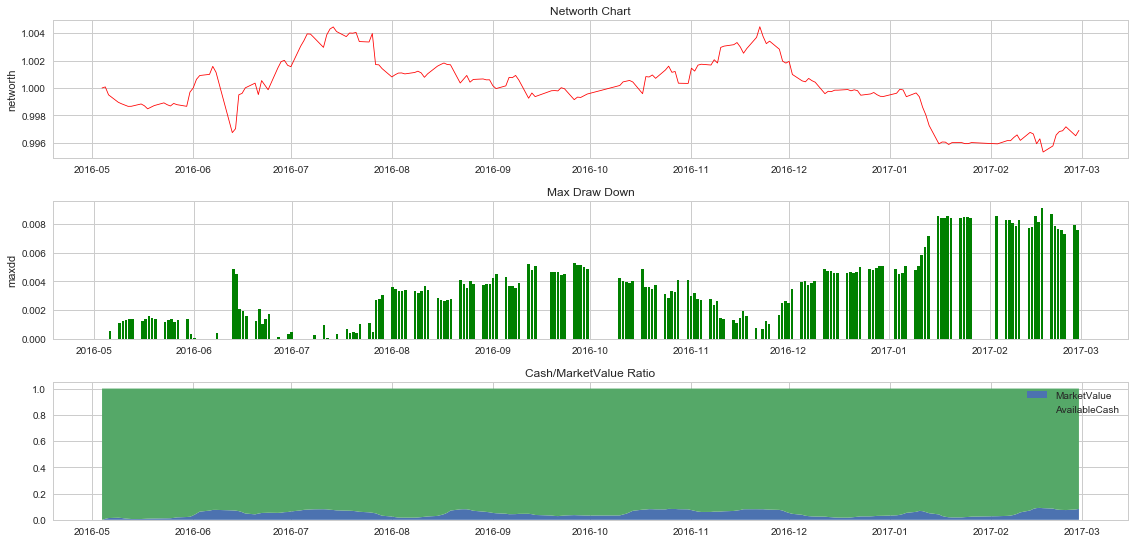

In [38]:
test.showBackTestingResult()